In [1]:
####################
# vvvvvvvvvvvvvvvvvvvvvvvvv
STORM_NUMBER = 20
# ^^^^^^^^^^^^^^^^^^^^^^^^^
####################
import datetime
import pytz
import pyproj
import verde as vd
from pyiem.plot import MapPlot, nwssnow
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from pyiem import iemre, reference
from pyiem.util import get_dbconn, utc
%matplotlib inline
cmap = nwssnow()
clevs = np.array([0.1, 1, 2, 3, 4, 6, 8, 12, 18, 24, 30, 36])

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
txt = """"""

def nice(val):
    """Pretty."""
    if val < 0.1 and val > 0:
        return "T"
    return "%.1f" % (val, )


def get_lsrs(sts, ets):
    ''' Return snowfall lsrs '''
    POSTGIS = get_dbconn('postgis', user='nobody')
    cursor = POSTGIS.cursor()
    data = []
    cursor.execute("""
    SELECT state, max(magnitude) as val, ST_x(geom) as lon, ST_y(geom) as lat
    from lsrs WHERE type in ('S') and magnitude > 0 and 
    valid >= %s and valid < %s and wfo in ('FSD', 'MPX', 'ARX', 'DVN', 'EAX', 'OAX', 'DMX')
    GROUP by state, lon, lat
    """, (sts, ets))
    for i, row in enumerate(cursor):
        data.append(
            dict(val=row[1], lat=row[3], lon=row[2], label='l%s' % (i,),
                 datalabel=nice(row[1]),
                 source='lsr', useme=True))
    
    cursor.close()
    POSTGIS.close()
    return data


def get_coop(dates):
    ''' Return snowfall obs for the given dates '''
    if len(dates) == 1:
        dates.append( dates[0] )
    IEM = get_dbconn('iem', user='nobody')
    cursor = IEM.cursor()
    data = []
    cursor.execute("""
    WITH obs as (
        SELECT s.iemid, count(*), sum(snow) from summary s JOIN stations t on (t.iemid = s.iemid)
        WHERE t.network in ('IACOCORAHS','IA_COOP', 'MN_COOP', 'WI_COOP', 'IL_COOP', 'MO_COOP',
        'KS_COOP', 'NE_COOP', 'SD_COOP') and s.day in """+str(tuple(dates))+""" 
        and snow >= 0 GROUP by s.iemid
    )
    SELECT id, obs.count, obs.sum, ST_x(geom), ST_y(geom), county from stations JOIN obs
    on (obs.iemid = stations.iemid)
    """)
    for row in cursor:
        #if row[1] != 2:
        #    print("skipping %s" % (row[0], ))
        #    continue
        data.append(
            dict(val=row[2], lat=row[4], lon=row[3], label=row[0],
                 datalabel=nice(row[2]),
                 source='coop', useme=False))
    
    cursor.close()
    IEM.close()
    return data

crows = get_coop( ['2020-02-09', '2020-02-10'] )
sts = utc(2020, 2, 9, 10)
ets = utc(2020, 2, 28, 23, 0)
lrows = get_lsrs(sts, ets)

df = pd.DataFrame(crows + lrows)
df.sort_values(by='val', ascending=False, inplace=True)
print("Found %s observations (%s coop/%s lsrs) for consideration" % (len(df.index), len(crows), len(lrows)))

# Now we filter the DataFrame
radii = 0.3

df['useme'] = False
newrows = []
i = 0
for lon in np.arange(reference.IA_WEST - 2, reference.IA_EAST + 2, radii):
    for lat in np.arange(reference.IA_SOUTH - 2, reference.IA_NORTH + 2, radii):
        hit = False
        for _radii in [radii, radii * 2., radii * 3.]:
            west = lon - (_radii / 2.)
            east = lon + (_radii / 2.)
            south = lat - (_radii / 2.)
            north = lat + (_radii / 2.)
            df2 = df[(df['lat'] >= south) & (df['lat'] < north) &
                     (df['lon'] >= west) & (df['lon'] < east)]
            if not df2.empty:
                hit = True
                if _radii == radii:
                    # cull any values less than 80% of local max
                    localmax = df2['val'].max() * 0.8
                    df.at[df2.index, 'useme'] = False
                    df.at[df2[df2['val']>=localmax].index, 'useme'] = True
                break
        if not hit:
            newrows.append(
                dict(val=0, lat=lat, lon=lon, label='i%s' % (i,),
                     datalabel="0",
                     source='int', useme=True))
            i += 1
dfall = df
#if newrows:
#    print("Added %s zero data points" % (len(newrows), ))
#    dfall = pd.concat([df, pd.DataFrame(newrows)], ignore_index=True)
dfall.set_index('label', inplace=True)


Found 1177 observations (719 coop/458 lsrs) for consideration


/home/akrherz/projects/pyIEM/src/pyiem/plot/geoplot.py:174: ResourceWarning: unclosed file <_io.BufferedReader name='/home/akrherz/projects/pyIEM/src/pyiem/plot/../data/us_states.pickle'>
  return pickle.load(open(fn, "rb"), **pickle_opts)
/home/akrherz/projects/pyIEM/src/pyiem/plot/geoplot.py:174: ResourceWarning: unclosed file <_io.BufferedReader name='/home/akrherz/projects/pyIEM/src/pyiem/plot/../data/us_states.pickle'>
  return pickle.load(open(fn, "rb"), **pickle_opts)


Gridder used: ScipyGridder(extra_args=None, method='cubic')
Data region: [-96.69999999999999, -90.09999999999997, 40.23950615983636, 43.73371911882519]
Generated geographic grid:


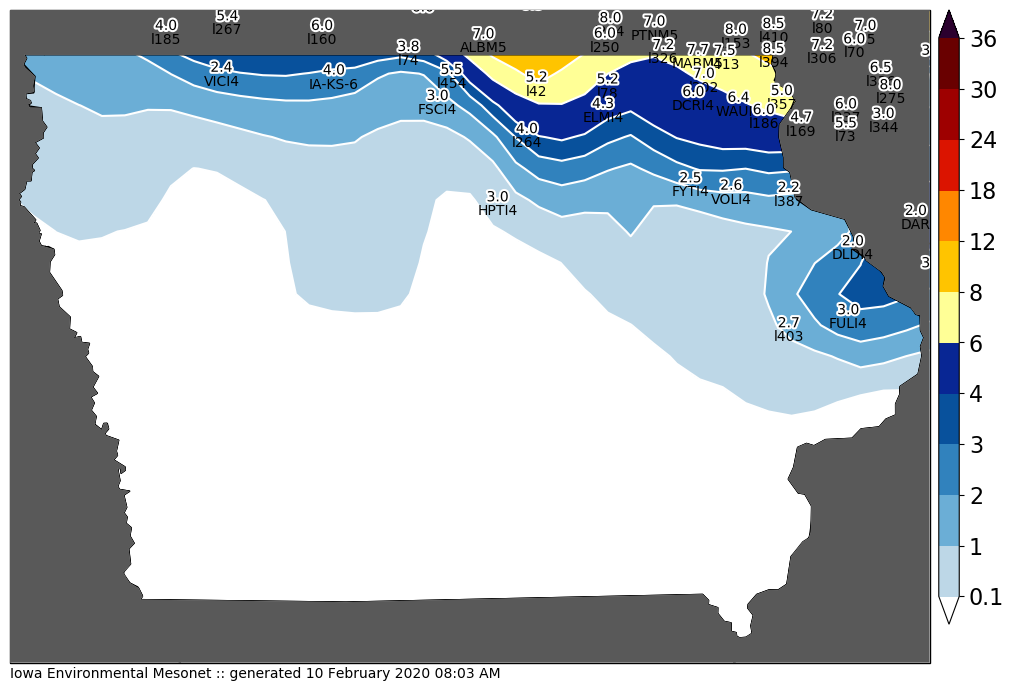

In [9]:
cull = []
if cull:
    dfall.at[cull, 'useme'] = False

hardcode = [
    ('SNYI4', 0.5),
]
    
           
for sid, val in hardcode:
    if sid not in dfall.index:
        print("%s was not found in index" % (sid, ))
        continue
    dfall.at[sid, 'val'] = val
    dfall.at[sid, 'datalabel'] = nice(val)

dfall.sort_values('val', ascending=True, inplace=True)
df_useme = dfall[dfall.useme]

# Our magic verde based gridding work here
m = MapPlot(state='IA', sector='state')
xbnds = m.ax.get_xlim()
ybnds = m.ax.get_ylim()
ll = ccrs.Geodetic().transform_point(
    xbnds[0], ybnds[0], m.ax.projection)
ul = ccrs.Geodetic().transform_point(
    xbnds[0], ybnds[1], m.ax.projection)
ur = ccrs.Geodetic().transform_point(
    xbnds[1], ybnds[1], m.ax.projection)
lr = ccrs.Geodetic().transform_point(
    xbnds[1], ybnds[0], m.ax.projection)
# We need to decimate
spacing = 0.5
reducer = vd.BlockReduce(reduction=np.max, spacing=spacing)
coordinates, data = reducer.filter(
    (df_useme['lon'].values, df_useme['lat'].values), df_useme['val'].values
)
# project to merc
projection = pyproj.Proj(proj="merc", lat_ts=42.)
proj_coordinates = projection(*coordinates)

# Now we can set up a gridder for the decimated data
grd = vd.ScipyGridder(method="cubic").fit(proj_coordinates, data)
#grd = vd.Spline().fit(proj_coordinates, data)
print("Gridder used:", grd)

# Get the grid region in geographic coordinates
region = [min(ll[0], ul[0]), max(lr[0], ur[0]), min(ll[1], ul[1]), max(ul[1], ur[1])]
print("Data region:", region)

grid = grd.grid(
    region=region,
    spacing=spacing / 3.,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["vals"],
)
print("Generated geographic grid:")

m.contourf(grid.longitude, grid.latitude, grid.vals, clevs, cmap=cmap)
df_useme_plot = df_useme[(df_useme['val']>=2)&(df_useme['val'] < 10)]
m.plot_values(
    df_useme_plot['lon'], df_useme_plot['lat'], df_useme_plot['datalabel'],
    '%s', labels=df_useme_plot.index.values,
    textsize=10, labeltextsize=10, labelbuffer=0)
m.postprocess(filename='test.png')

/home/akrherz/projects/pyIEM/src/pyiem/plot/geoplot.py:174: ResourceWarning: unclosed file <_io.BufferedReader name='/home/akrherz/projects/pyIEM/src/pyiem/plot/../data/ugcs_county.pickle'>
  return pickle.load(open(fn, "rb"), **pickle_opts)


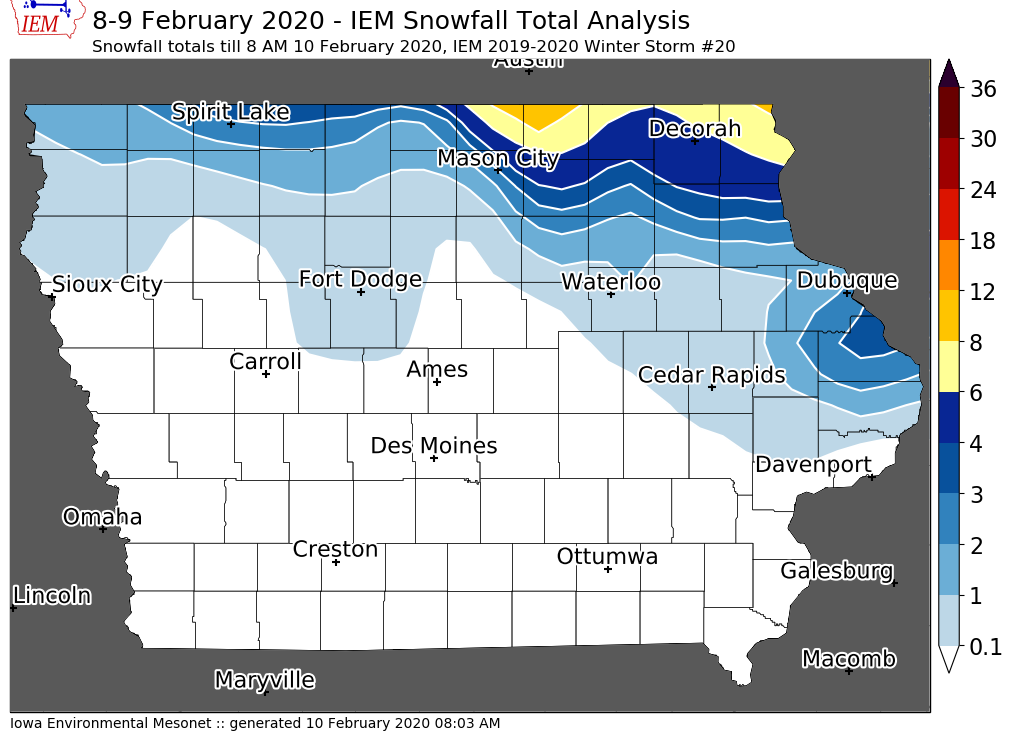

In [8]:
# now we are ready to plot!

m = MapPlot(sector='iowa',
            title='8-9 February 2020 - IEM Snowfall Total Analysis',
            subtitle=("Snowfall totals till 8 AM 10 February 2020, "
                      "IEM 2019-2020 Winter Storm #%s") % (STORM_NUMBER, ))
vals = m.contourf(grid.longitude, grid.latitude, grid.vals, clevs, cmap=cmap)
#m.plot_values(np.array(df2.lon), np.array(df2.lat), np.array(df2.val), '%.2f')
m.drawcounties()
m.drawcities()
m.postprocess(filename='200210.png')